<a href="https://colab.research.google.com/github/lynkos/algae-detection/blob/main/src/model_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

Check if you have access to GPU.

In [ ]:
!nvidia-smi

Sat Apr 20 18:28:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

Install required packages and get home directory.

In [ ]:
!pip install roboflow ultralytics

from os import getcwd
from IPython.display import clear_output, display, Image
from ultralytics import checks, YOLO

ROOT = getcwd()
clear_output()
checks()

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Setup complete ✅ (8 CPUs, 51.0 GB RAM, 29.3/201.2 GB disk)


## Prepare custom dataset

1. Create or login to a Roboflow [account](https://app.roboflow.com/login)

2. Go to the [homepage](https://app.roboflow.com) and create a workspace
<div align="center">
  <img
    width="640"
    alt="Create Roboflow workspace"
    src="https://github.com/lynkos/algae-detection/assets/9407943/68d3c544-4c84-4f1a-ad28-f928b1e4b90d"
  >
</div>

3. Invite up to 2 teammates (paid users can add more) to the workspace
<div align="center">
  <img
    width="640"
    alt="Invite teammates to Roboflow workspace"
    src="https://github.com/lynkos/algae-detection/assets/9407943/d1332993-de33-4dbd-9ef8-1f12cb1ad0aa"
  >
</div>

4. Create a new 'Object Detection' project within the workspace, then open/enter it
<div align="center">
  <img
    width="640"
    alt="Create new object detection project in Roboflow"
    src="https://github.com/lynkos/algae-detection/assets/9407943/a6df2ea9-f21b-4e93-b30d-e59814c493c6"
  >
</div>

5. Click 'Classes' in the project sidebar, add all the categories (i.e., classes) of algae within the dataset (separated by commas), then press 'Add Classes'
<div align="center">
  <img
    width="640"
    alt="Add classes"
    src="https://github.com/lynkos/algae-detection/assets/9407943/31b28533-77b1-47a8-b152-11c5029477d8"
  >
</div>
In this case, the classes are `closterium, microcystis, nitzschia, oscillatoria`
<div align="center">
  <img
    width="640"
    alt="Added classes"
    src="https://github.com/lynkos/algae-detection/assets/9407943/1047d7b0-75be-49ea-a60c-00ef315a7cfc"
  >
</div>

6. [Add](https://docs.roboflow.com/datasets/adding-data) [dataset](https://drive.google.com/drive/folders/1gd85o6dpcjDwWJUUi4x9slhjHHuoY4K0) to project
<ul>
  <li>When you first create a project, you will automatically be asked to upload images</li>
  <li>If you already have a project, click 'Upload Data' in the project sidebar</li>
</ul>
Upload each class in separate batches (i.e., upload each folder individually) and tag each batch with its respective class name to make annotating easier
<div align="center">
  <img
    width="640"
    alt="Upload dataset"
    src="https://github.com/lynkos/algae-detection/assets/9407943/145e18fc-ace8-45fe-8491-5bc2d6c4962c"
  >
</div>

7. Once you're at the 'Annotate' tab of the project sidebar, click 'Start Manual Labeling'
<div align="center">
  <img
    width="640"
    alt="Manually label dataset"
    src="https://github.com/lynkos/algae-detection/assets/9407943/cf1663a3-08b0-47d2-9454-56c9b23b7d20"
  >
</div>

8. Search for and add your teammates in order to evenly divide the work, then click 'Assign Images'
<div align="center">
  <img
    width="640"
    alt="Divide and assign images to teammates"
    src="https://github.com/lynkos/algae-detection/assets/9407943/78212a07-993d-4f02-a4a9-b436befb14f4"
  >
</div>

9. Click 'Upload Data' in the project sidebar and repeat steps 6 thru 8 for each class (i.e., type of algae) before continuing

10. Click '[Annotate](https://docs.roboflow.com/annotate)' in the project sidebar to view the annotation jobs board, find your job, and click 'Start Annotating'
<div align="center">
  <img
    width="640"
    alt="Annotation jobs board"
    src="https://github.com/lynkos/algae-detection/assets/9407943/0c35e846-cbab-46d8-a123-ef34fc6c4650"
  >
</div>
Progress is automatically saved, so you don't have to do it all in one sitting
<div align="center">
  <img
    width="640"
    alt="Annotation page"
    src="https://github.com/lynkos/algae-detection/assets/9407943/49ddb540-f830-495a-a3a8-786ed3966ec5"
  >
</div>

11. For each image, click the '[Smart Polygon](https://docs.roboflow.com/annotate/use-roboflow-annotate/smart-polygon)' button in the labeling toolbar on the right-hand side (or press its shortcut key '`S`')
<div align="center">
  <img
    width="640"
    alt="Smart polygon tool"
    src="https://github.com/lynkos/algae-detection/assets/9407943/a340aa18-50cb-483f-9675-fa5a5d1a8f56"
  >
</div>

12. Click 'Standard'
<div align="center">
  <img
    width="640"
    alt="Standard smart polygon tool"
    src="https://github.com/lynkos/algae-detection/assets/9407943/395b304b-015f-41cf-85c5-708c8db22fb4"
  >
</div>

13. Click the center of the algae to automatically generate its bounds; adjust as needed by clicking outside the shape to add areas that need to be highlighted or clicking inside the shape to remove areas that are highlighted
<div align="center">
  <img
    width="640"
    alt="Bound algae"
    src="https://github.com/lynkos/algae-detection/assets/9407943/c5e58970-30f4-4d5a-a152-50eed7e6c450"
  >
</div>
Use the 'Complex' labels option (i.e., the star) and make sure the shape is as close as possible to the algae before pressing 'Enter' or clicking the 'Finish (Enter)' button

14. Select the correct class (view the tags for that information), make any modifications to the shape (via the white squares surrounding the algae), then press 'Enter' or click the 'Save (Enter)' button
<div align="center">
  <img
    width="640"
    alt="Assign class to bound algae"
    src="https://github.com/lynkos/algae-detection/assets/9407943/cb8b168f-b1d7-4175-a3a0-bbe0210f7434"
  >
</div>

15. The result should now look like this; press '→' key or click the arrow button on the top to continue onto the next image and repeat steps 11 thru 15 until all images are annotated
<div align="center">
  <img
    width="640"
    alt="Annotated algae"
    src="https://github.com/lynkos/algae-detection/assets/9407943/36388d76-7a46-4ca8-bf17-1610a344d6c5"
  >
</div>

16. Go back to the 'Annotate' section and click 'Add _ image(s) to Dataset'
<div align="center">
  <img
    width="640"
    alt="Add annotated images to dataset"
    src="https://github.com/lynkos/algae-detection/assets/9407943/88084073-844d-4d7a-94de-d160dd6b9d1c"
  >
</div>

17. Choose your preferred Test/Valid/Train split, then click 'Add Images'; we used the standard 70%-20%-10% split
<div align="center">
  <img
    width="640"
    alt="Choose Test/Valid/Train split"
    src="https://github.com/lynkos/algae-detection/assets/9407943/7d2102ef-57d6-4075-ab16-830ccc15eb97"
  >
</div>

18. Once all images are annotated, click 'Generate' in the project sidebar, choose your preferred 'Preprocessing' and 'Augmentation', then create dataset (choose the option with the most images)
<div align="center">
  <img
    width="640"
    alt="Generate new dataset"
    src="https://github.com/lynkos/algae-detection/assets/9407943/d3f92913-f943-478f-822f-b1fe47231e7b"
  >
</div>

19. Click 'Versions' in the project sidebar, go to your newly generated dataset, and click 'Export Dataset' in the upper-right corner
<div align="center">
  <img
    width="640"
    alt="Export dataset"
    src="https://github.com/lynkos/algae-detection/assets/9407943/a5cf1aca-6ec3-43d2-8d36-3fda160708b5"
  >
</div>

20. Choose 'YOLOv8' format and click 'show download code' before clicking 'Continue'
<div align="center">
  <img
    width="640"
    alt="Choose dataset download format"
    src="https://github.com/lynkos/algae-detection/assets/9407943/2b092377-b4f7-4d58-b4f2-7f7b82cc0cec"
  >
</div>

21. Copy the code snippet provided in the 'Jupyter' section, then click 'Done'
<div align="center">
  <img
    width="640"
    alt="Python code snippet for downloading dataset in notebook"
    src="https://github.com/lynkos/algae-detection/assets/9407943/583a2587-0ade-4d77-b246-79a67bab889f"
  >
</div>

## Import existing dataset

Create new directory to store dataset.

In [ ]:
!mkdir {ROOT}/datasets

From the code snippet you copied in step #21 of the 'Prepare custom dataset' (i.e., previous) section, find your:
* Roboflow API Key
* Workspace Name
* Project Name
* Dataset Version

Here's a labeled example:
<div align="center">
  <img
    width="640"
    alt="Labeled code snippet with dataset constants"
    src="https://github.com/lynkos/algae-detection/assets/9407943/3219f874-bcbe-46d2-aca7-e86eb728613b"
  >
</div>

Once you have those 4 things:
1. Click the key button (i.e., 'Secrets' tab) in the left panel to add your Roboflow API key
2. Click **+ Add new secret**
3. Input `ROBOFLOW_API_KEY` within **Name** column
4. Paste your [Roboflow API key](https://docs.roboflow.com/api-reference/authentication#retrieve-an-api-key) (WITHOUT quotations) within **Value** column
5. Toggle **Notebook access** on
6. Replace `WORKSPACE`, `PROJECT_NAME`, and `VERSION` constants with your workspace name, project name, and dataset version respectively

In [ ]:
from google.colab import userdata

ROBOFLOW_API_KEY = userdata.get("ROBOFLOW_API_KEY")
WORKSPACE = "capstone2algae"
PROJECT_NAME = "algae-detection-1opyx"
VERSION = 18

Download dataset into datasets directory.

In [ ]:
%cd {ROOT}/datasets

from roboflow import Roboflow

PROJECT = Roboflow(api_key = ROBOFLOW_API_KEY).workspace(WORKSPACE).project(PROJECT_NAME)
PROJECT_VERSION = PROJECT.version(VERSION)
DATASET = PROJECT_VERSION.download("yolov8")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to algae-detection-18 in yolov9:: 100%|██████████| 2024/2024 [00:00<00:00, 10407.65it/s]


## Custom Training

[Train YOLO](https://docs.ultralytics.com/modes/train) on [Detect](https://docs.ultralytics.com/tasks/detect) datasets.

`PRE_TRAINED_MODEL` parameter can be changed to your preferred model.

In [ ]:
from torch import device
from torch.cuda import is_available

DEVICE = device("cuda" if is_available() else "cpu")
DATASET_PATH = DATASET.location
IMG_SIZE = 256
EPOCHS = 25
BATCHES = -1
WORKERS = 8
PRE_TRAINED_MODEL = "yolov8s.pt"
DATASET_CFG = f"{DATASET_PATH}/data.yaml"
RESULTS_DIR = f"{DATASET.name}-{VERSION}"

Create new directory to store training results.

In [ ]:
%cd {ROOT}

!mkdir {ROOT}/results

In [ ]:
%cd {ROOT}/results

!mkdir {RESULTS_DIR}

/content/results


Open `data.yml` (located at `DATASET_CFG`) and make sure the `test`, `train`, `val` values look like so before continuing:
```
test: test/images
train: train/images
val: valid/images
```

### CLI

In [ ]:
!yolo task=detect mode=train model={PRE_TRAINED_MODEL} name={PRE_TRAINED_MODEL} imgsz={IMG_SIZE} workers={WORKERS} patience={EPOCHS} batch={BATCHES} project={RESULTS_DIR} cache=True data={DATASET_CFG} epochs={EPOCHS} plots=True

### Python SDK

In [ ]:
YOLO(PRE_TRAINED_MODEL, task = "detect").train(data = DATASET_CFG, patience = EPOCHS, name = PRE_TRAINED_MODEL, workers = WORKERS, project = RESULTS_DIR, epochs = EPOCHS, batch = BATCHES, imgsz = IMG_SIZE, cache = True, plots = True)

### Training output

View contents of directory containing saved training results.

In [ ]:
TRAIN_DIR = f"{ROOT}/{RESULTS_DIR}/{PRE_TRAINED_MODEL}"
!ls {TRAIN_DIR}

args.yaml					    P_curve.png		train_batch196.jpg
confusion_matrix_normalized.png			    PR_curve.png	train_batch197.jpg
confusion_matrix.png				    R_curve.png		train_batch1.jpg
events.out.tfevents.1713500219.9ac76b3f60ca.3081.0  results.csv		train_batch2.jpg
F1_curve.png					    results.png		val_batch0_labels.jpg
labels_correlogram.jpg				    train_batch0.jpg	val_batch0_pred.jpg
labels.jpg					    train_batch195.jpg	weights


Define helper function to show images.

In [ ]:
from IPython.display import Image, display

def output_img(path, width = 600):
    display(Image(filename = path, width = width))

Output some charts within the aforementioned directory.

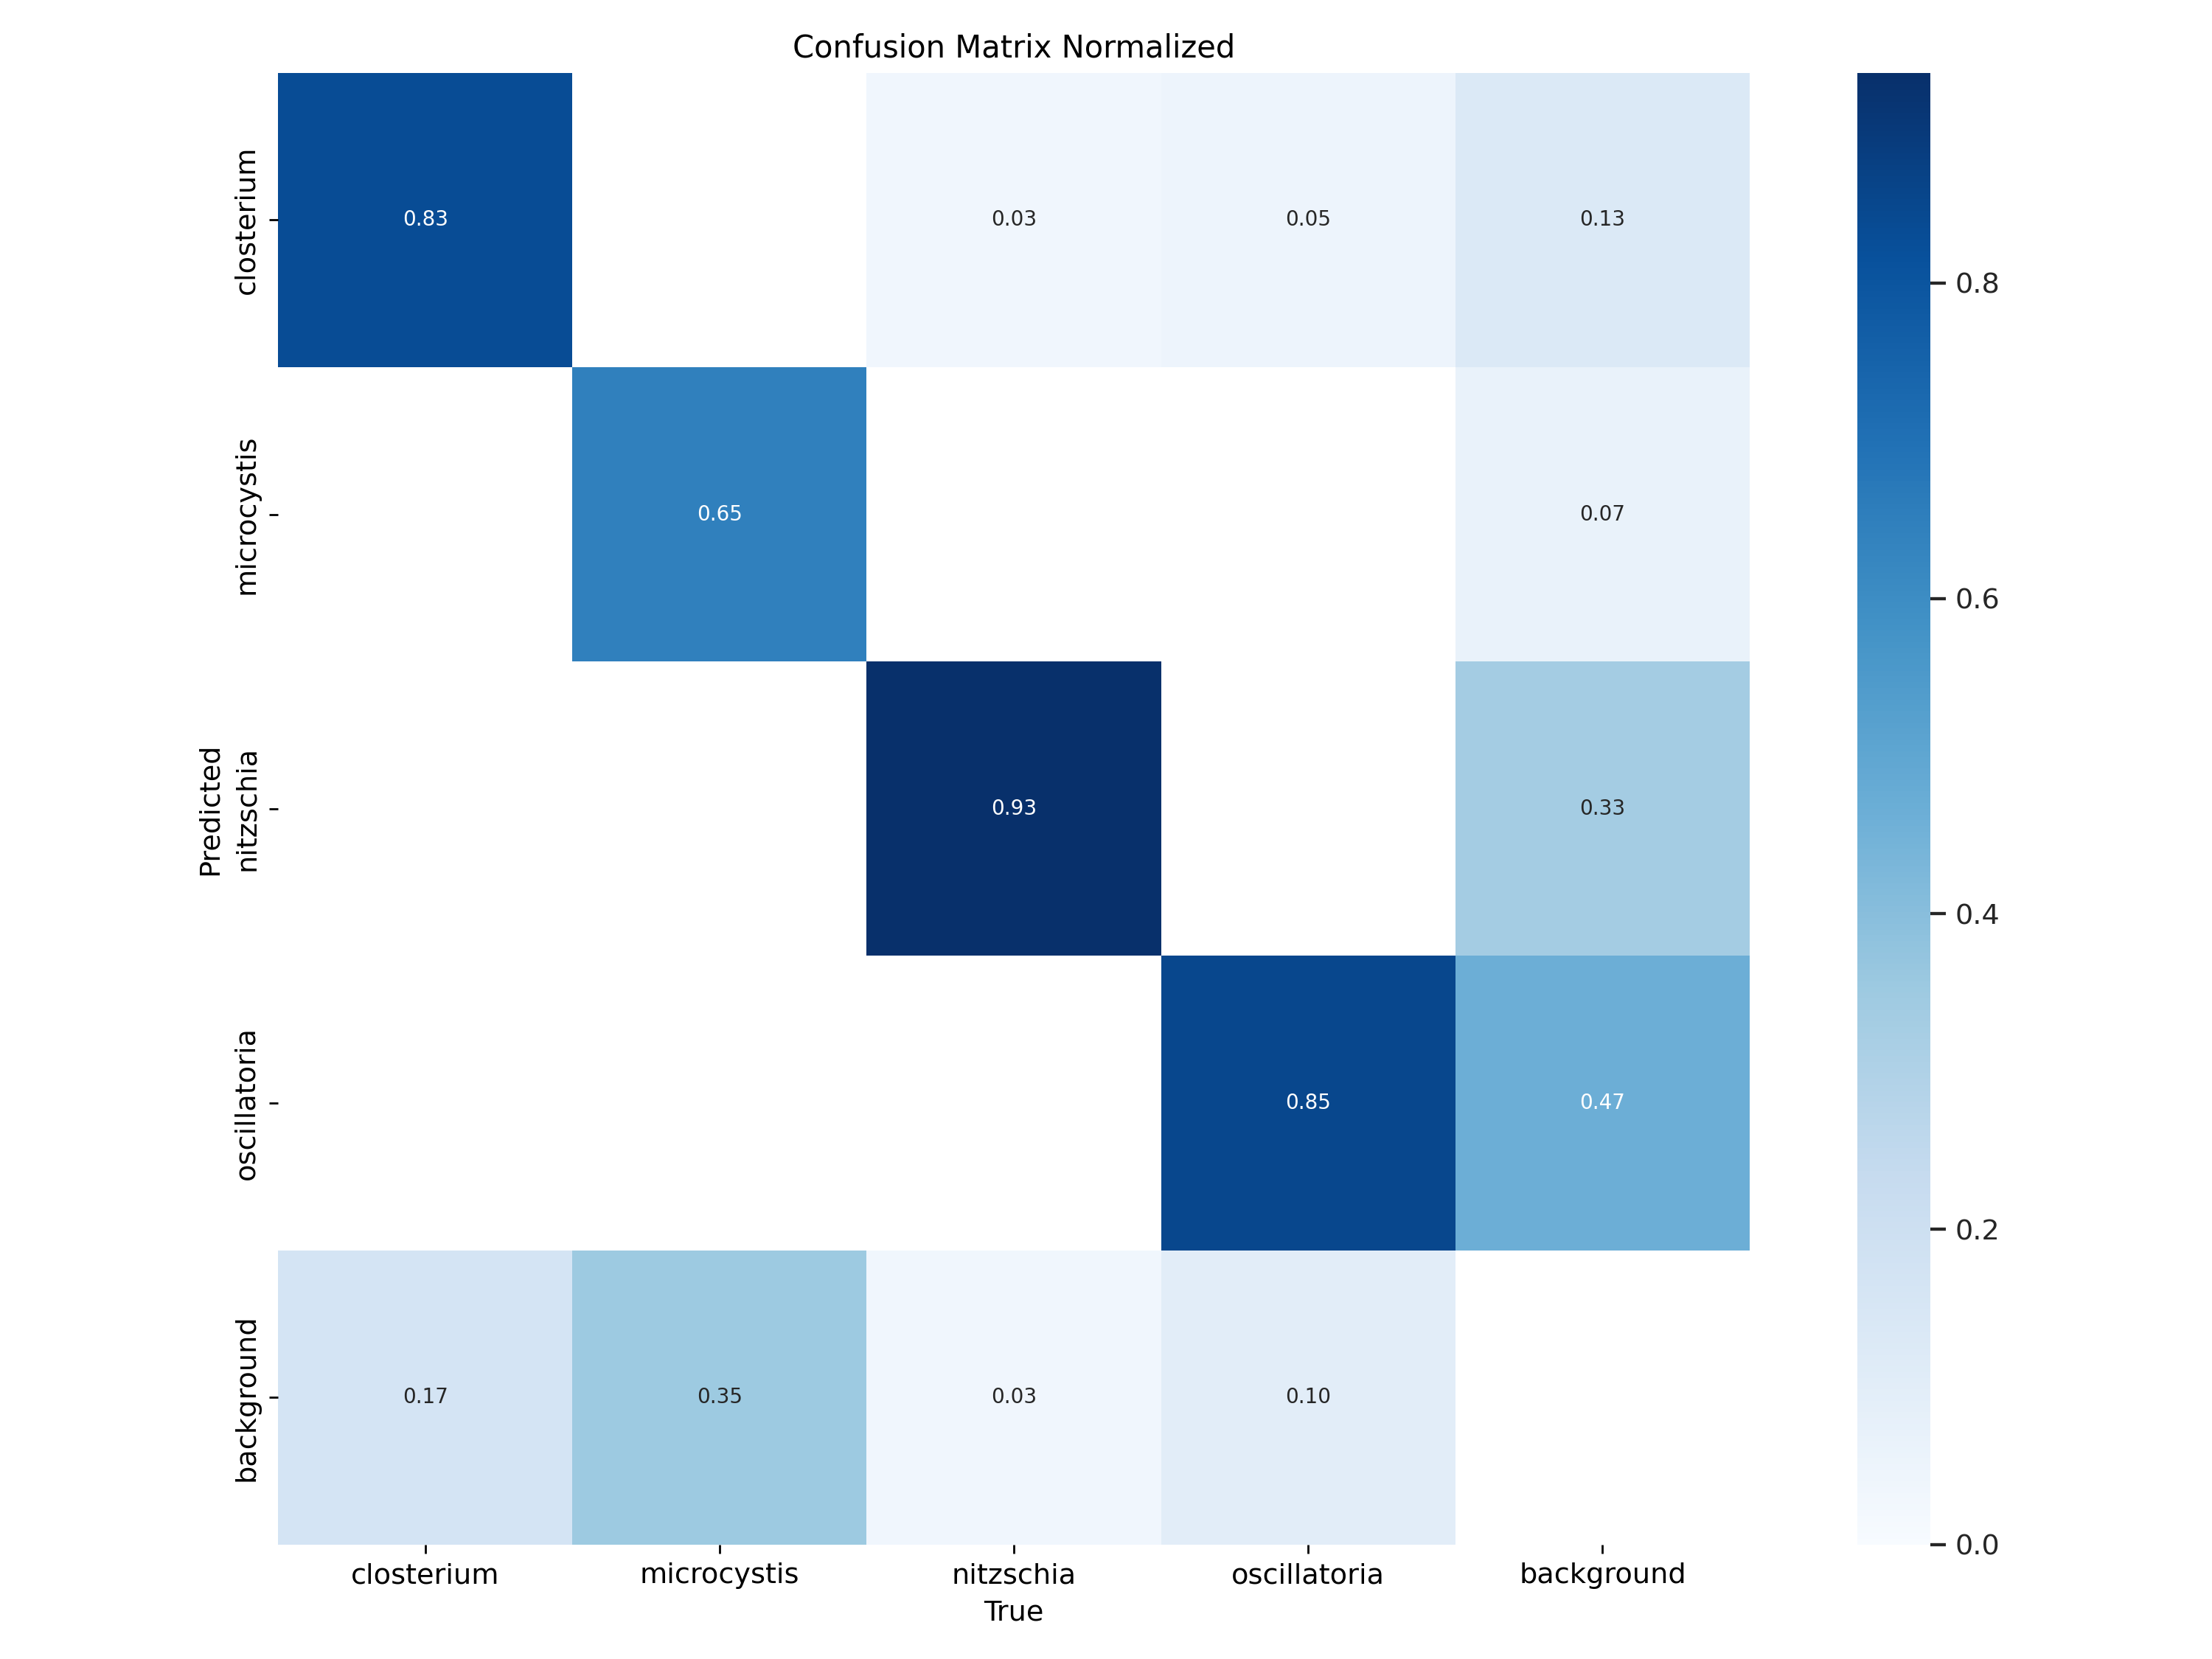

In [ ]:
output_img(f"{TRAIN_DIR}/confusion_matrix_normalized.png")

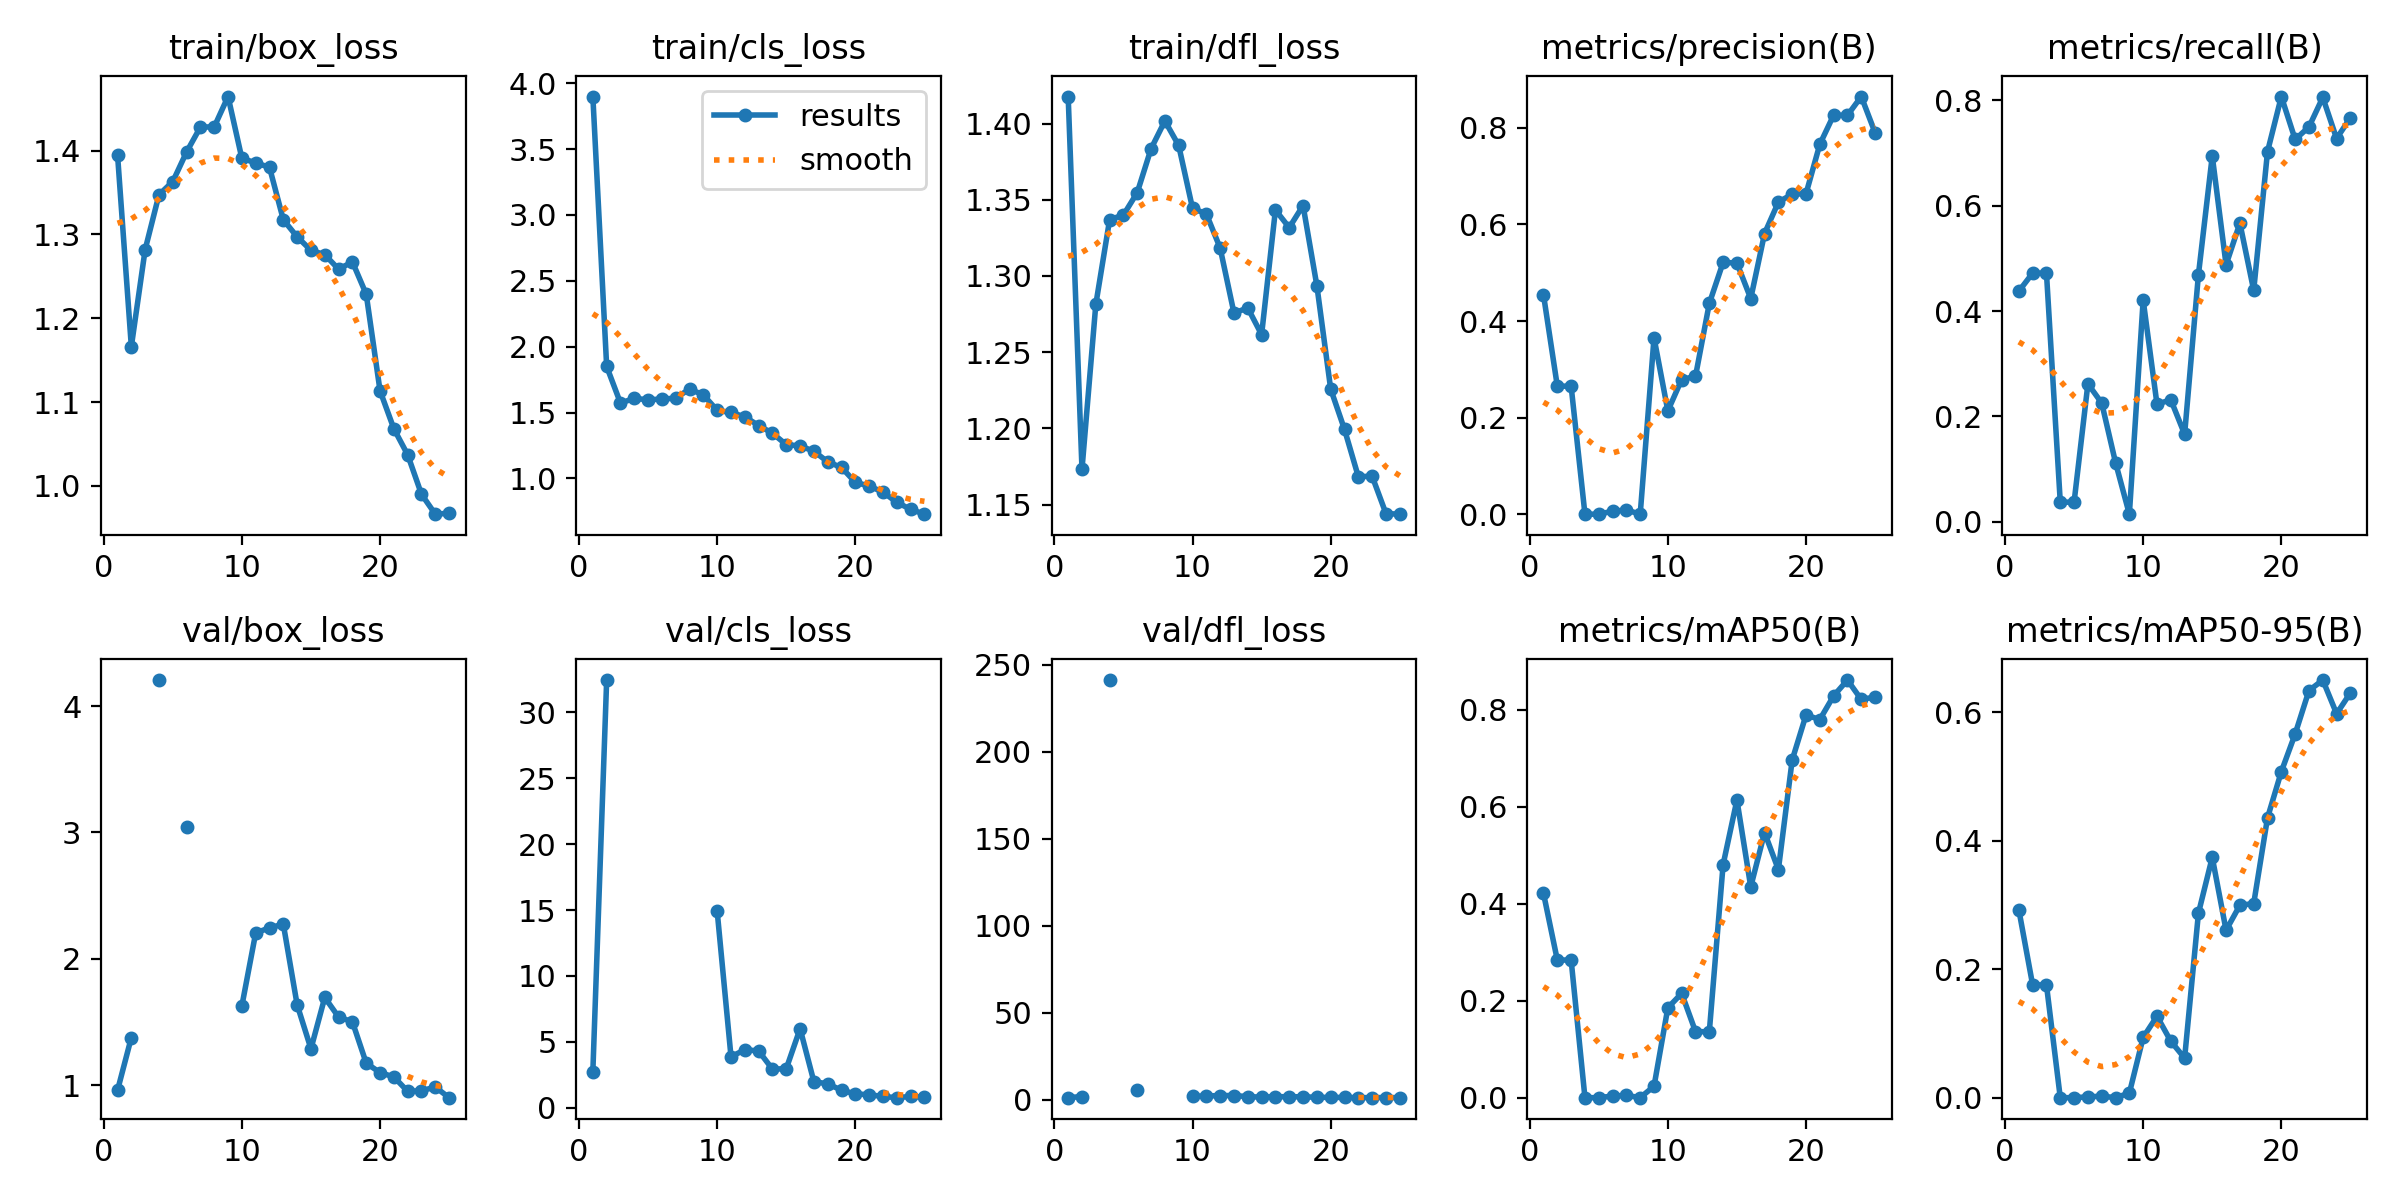

In [ ]:
output_img(f"{TRAIN_DIR}/results.png")

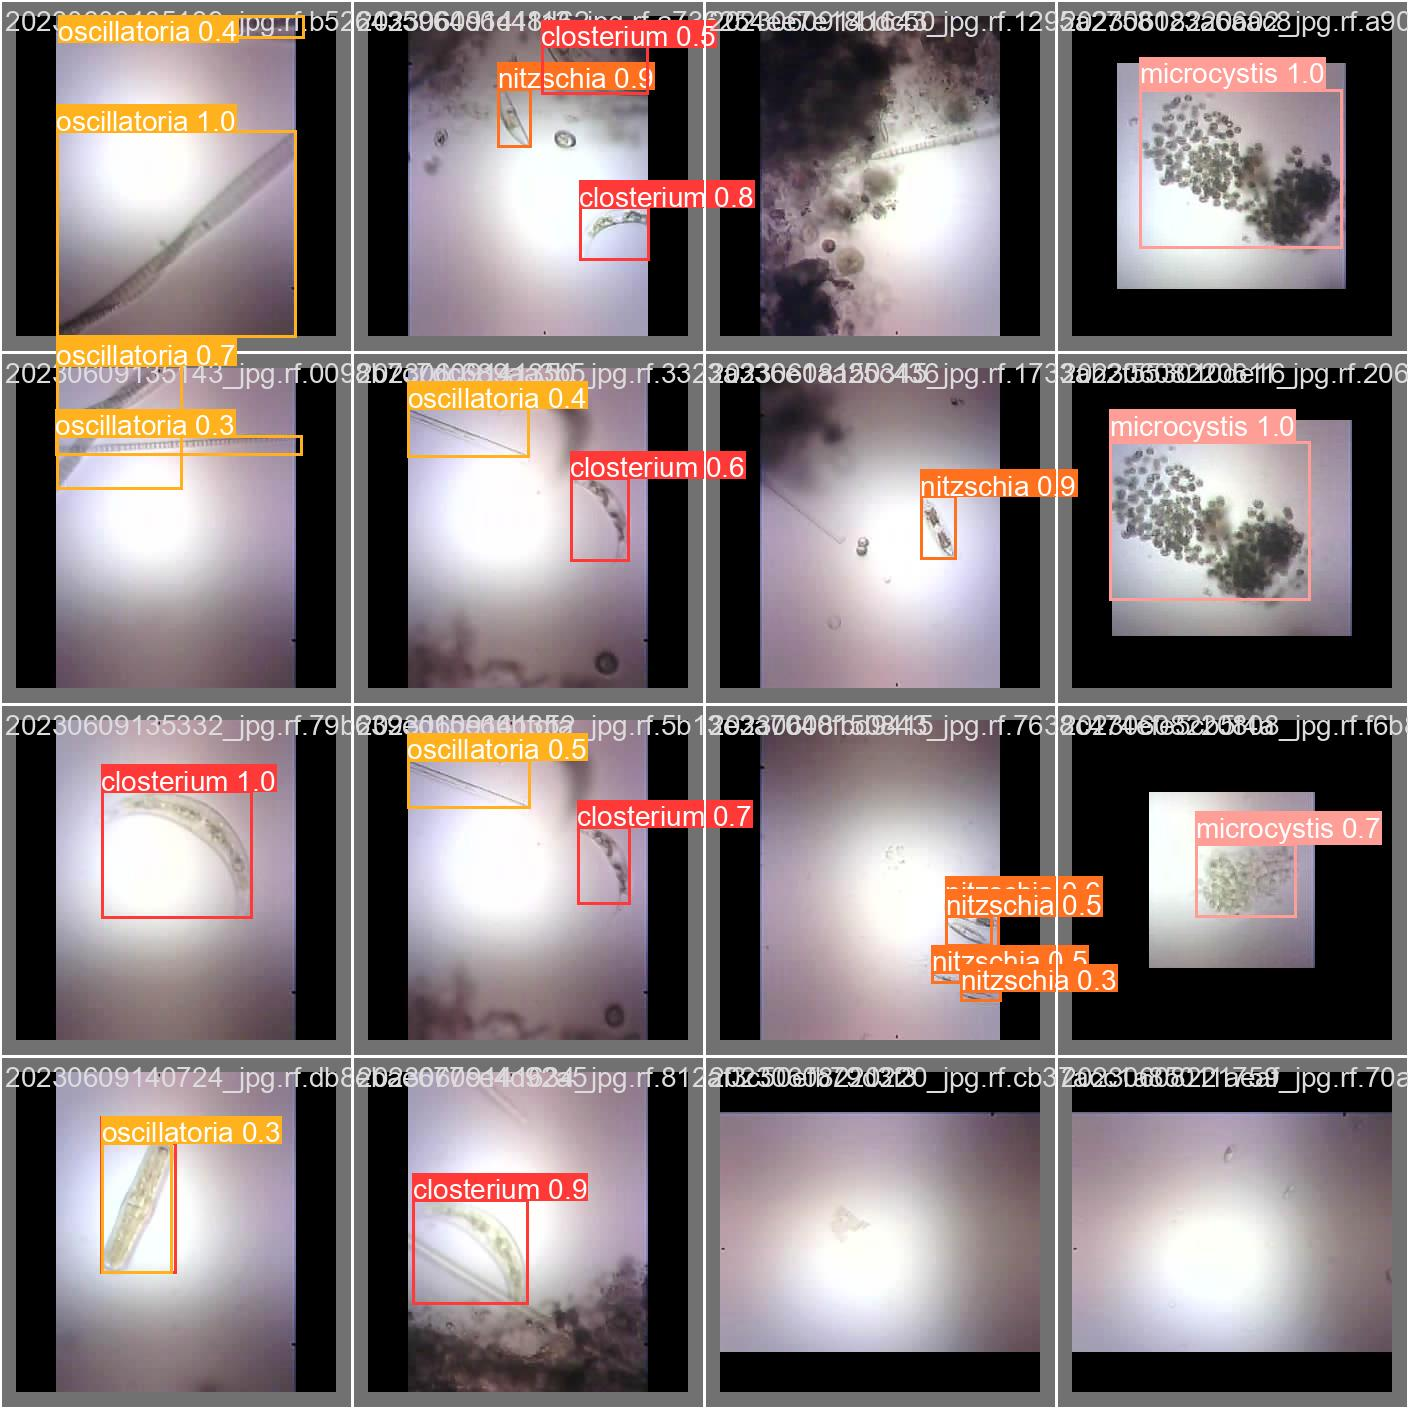

In [ ]:
output_img(f"{TRAIN_DIR}/val_batch0_pred.jpg")

## Validate Custom Model

Newly trained weights are located at `{TRAIN_DIR}/weights/best.pt`.

In [ ]:
%cd {TRAIN_DIR}

CUSTOM_MODEL_PATH = f"{TRAIN_DIR}/weights/best.pt"
CONFIDENCE = 0.25
IOU = 0.25
VAL_BATCH = BATCHES

/content/algae-detection-16/yolov8x.pt


### CLI

In [ ]:
!yolo task=detect mode=val device={DEVICE} batch={VAL_BATCH} plots=True iou={IOU} model={CUSTOM_MODEL_PATH} data={DATASET_CFG} imgsz={IMG_SIZE} conf={CONFIDENCE}

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
rt-detr-l summary: 498 layers, 31991960 parameters, 0 gradients
val: Scanning /content/datasets/algae-detection-15/valid/labels.cache... 82 images, 15 backgrounds, 0 corrupt: 100% 82/82 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 6/6 [00:02<00:00,  2.75it/s]
                   all         82         85      0.879      0.784      0.864      0.678
            closterium         82         18      0.928      0.944      0.982      0.797
           microcystis         82         17       0.99      0.529      0.698      0.566
             nitzschia         82         30       0.89      0.807      0.

### Python SDK

In [ ]:
YOLO(CUSTOM_MODEL_PATH).val(data = DATASET_CFG,
                            device = DEVICE,
                            plots = True,
                            iou = IOU,
                            batch = VAL_BATCH,
                            imgsz = IMG_SIZE,
                            conf = CONFIDENCE)

## Inference with Custom Model

Helper function to choose random test image.

In [ ]:
from os import listdir
from random import choice

def get_random_test_img(ds_path = DATASET_PATH):
  test_dir = f"{ds_path}/test/images"
  rand_img = choice(listdir(test_dir))
  print("Running inference on", rand_img)

  return f"{test_dir}/{rand_img}"

### CLI

In [ ]:
!yolo task=detect mode=predict model={CUSTOM_MODEL_PATH} augment=True agnostic_nms=True device={DEVICE} imgsz={IMG_SIZE} conf={CONFIDENCE} iou={IOU} source={DATASET_PATH}/test/images save=True

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 268 layers, 68127420 parameters, 0 gradients, 257.4 GFLOPs

image 1/42 /content/datasets/algae-detection-16/test/images/20230608150016_jpg.rf.50d6c8216a732ab440067b0f43535bc5.jpg: 320x320 (no detections), 346.1ms
image 2/42 /content/datasets/algae-detection-16/test/images/20230608154221_jpg.rf.64ce5fb20f19cae96faa5c7ebb9e4139.jpg: 320x320 (no detections), 37.3ms
image 3/42 /content/datasets/algae-detection-16/test/images/20230608154831_jpg.rf.0ad7d3ef59bfdc1de82808cc0ca652f0.jpg: 320x320 (no detections), 38.0ms
WARNING ⚠️ NMS time limit 0.550s exceeded
image 4/42 /content/datasets/algae-detection-16/test/images/20230608155623_jpg.rf.8160518c4b3ef97bcf2861686ce66756.jpg: 320x320 1 closterium, 36.1ms
image 5/42 /content/datasets/algae-detection-16/test/images/20230608222002_jpg.rf.2a665deac757c91eb47045e0936daf07.jpg: 320x320 1 microcystis, 37.8ms
image 6/42 /content/datasets/a

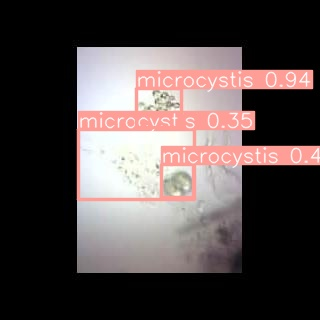

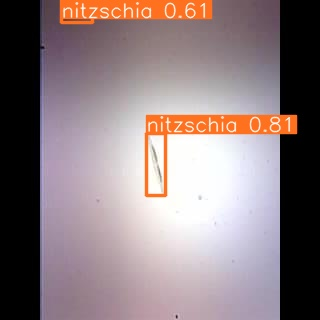

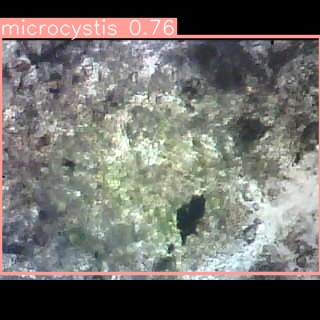

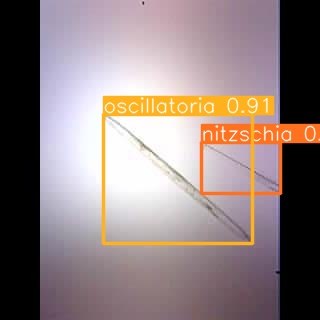

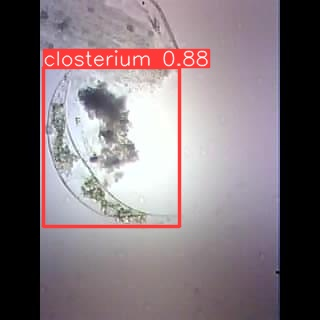

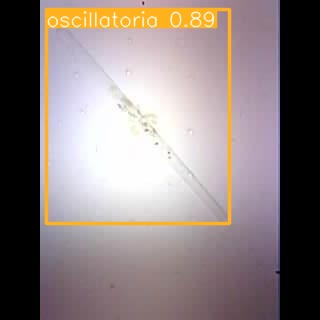

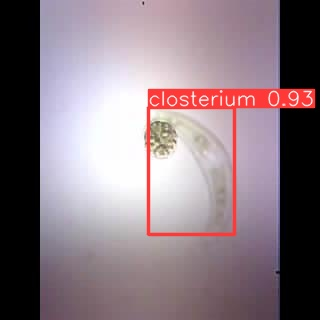

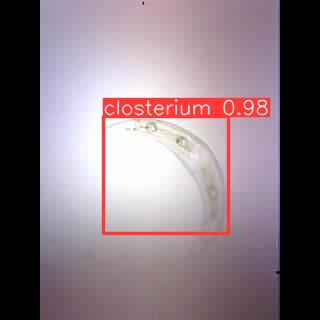

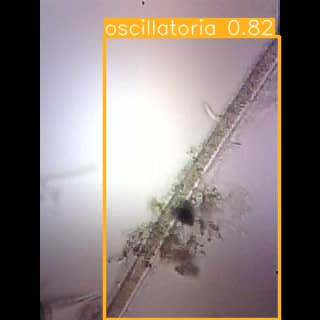

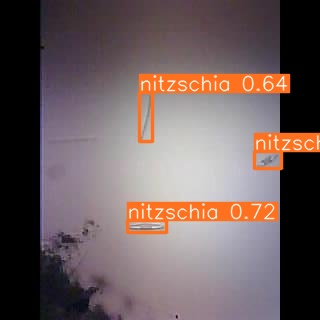

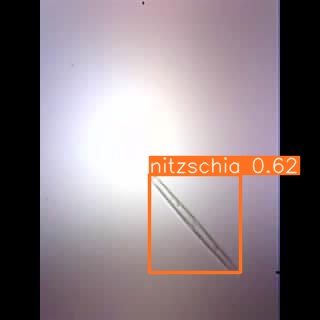

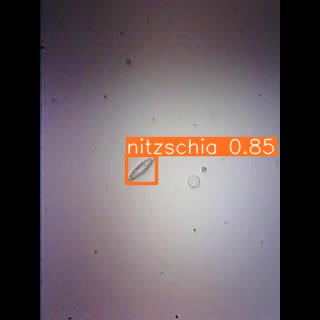

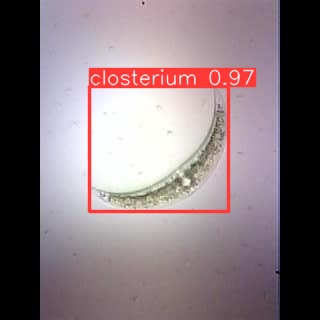

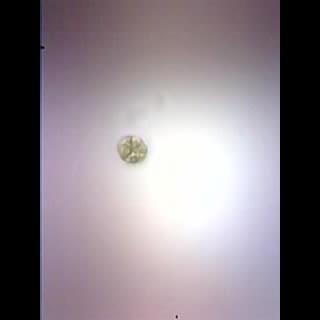

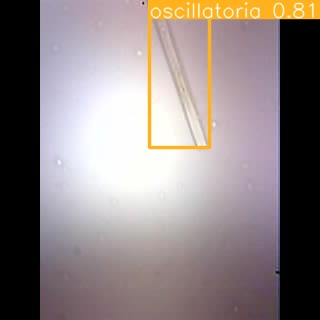

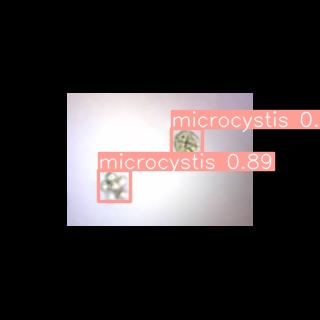

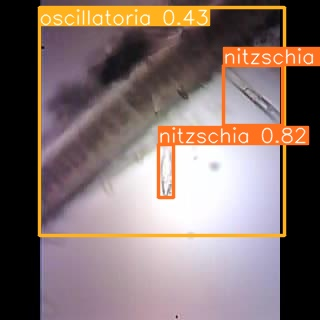

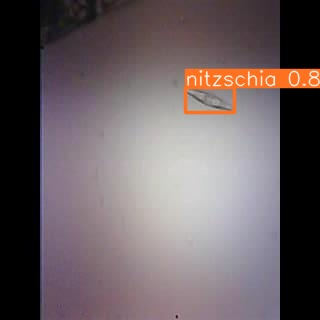

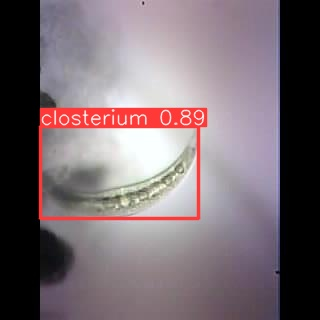

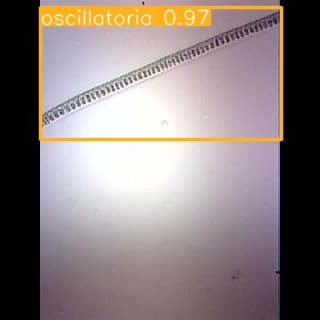

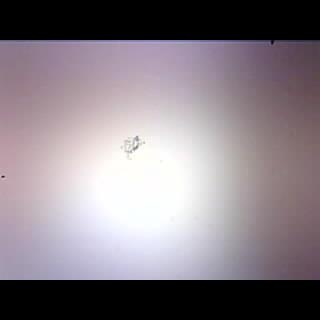

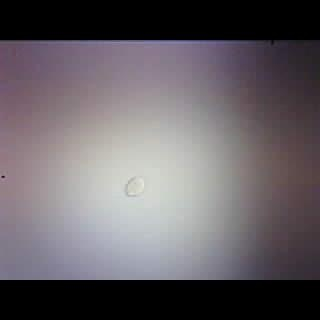

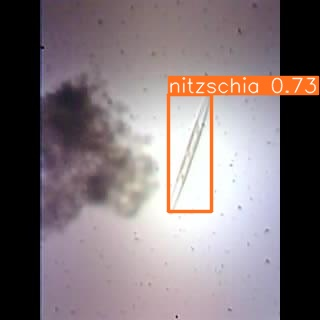

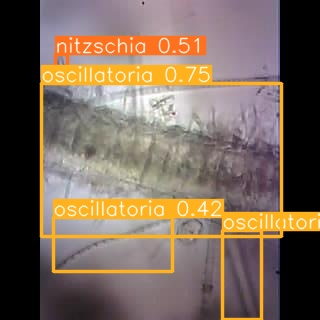

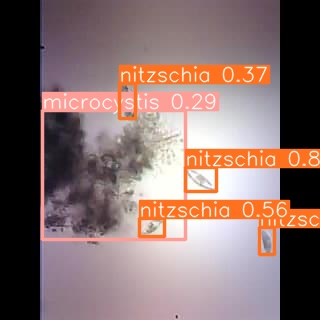

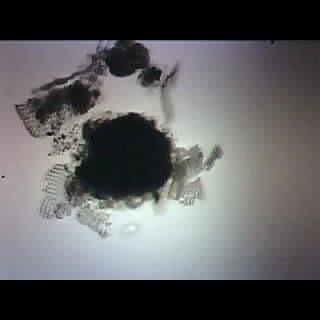

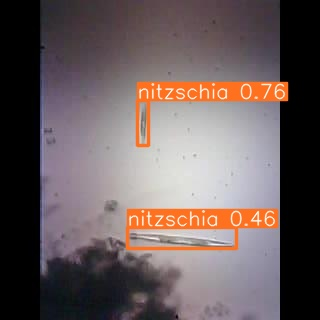

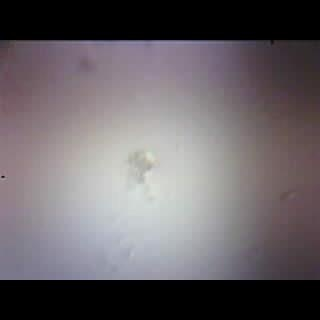

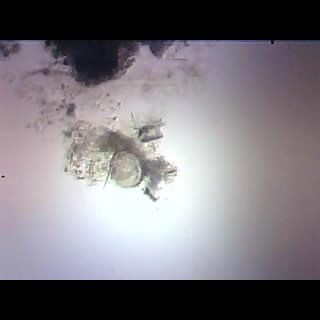

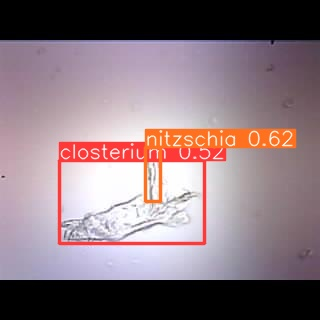

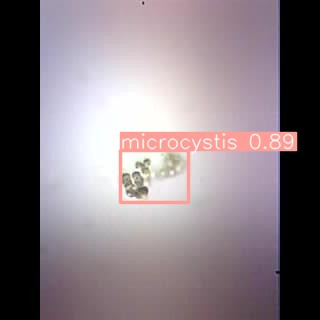

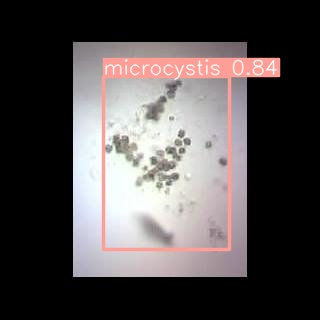

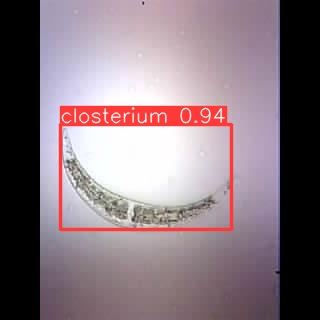

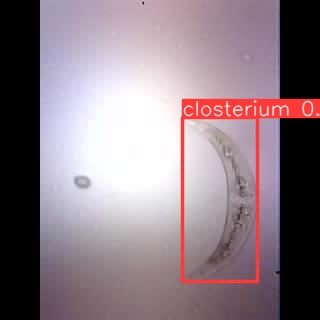

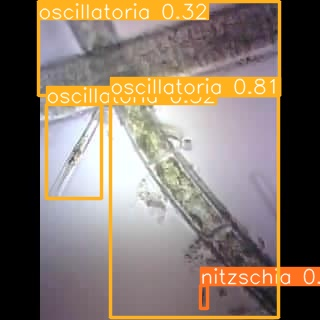

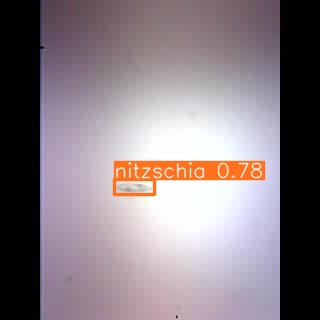

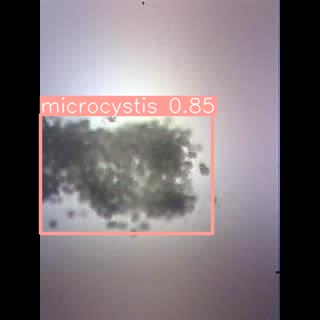

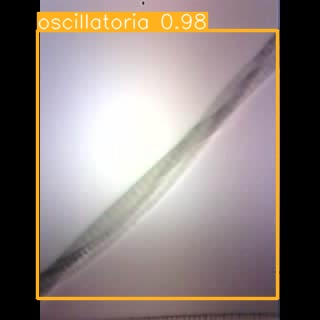

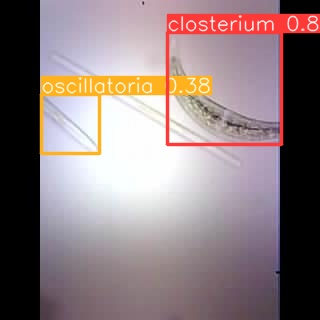

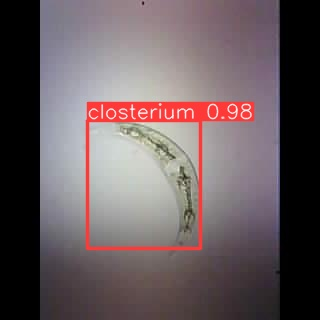

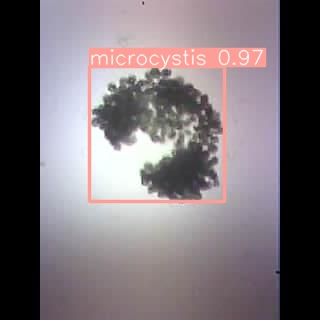

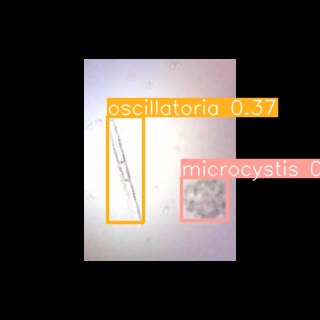

In [ ]:
from glob import glob
from IPython.display import Image, display

for image_path in glob(f"{TRAIN_DIR}/runs/detect/predict/*.jpg"):
      output_img(image_path)
      print("\n")

New YOLO model

In [ ]:
CUSTOM_MODEL = YOLO(CUSTOM_MODEL_PATH, task = "detect")

### Python SDK

In [ ]:
CUSTOM_MODEL.predict(get_random_test_img(), save = True, imgsz = IMG_SIZE, conf = CONFIDENCE)

## Export Model

Export a YOLOv8 model to any supported format below with the `format` argument, i.e. `format=onnx`. See [YOLOv8 Export Docs](https://docs.ultralytics.com/modes/export/) for more information.

- 💡 ProTip: Export to [ONNX](https://docs.ultralytics.com/integrations/onnx/) or [OpenVINO](https://docs.ultralytics.com/integrations/openvino/) for up to 3x CPU speedup.  
- 💡 ProTip: Export to [TensorRT](https://docs.ultralytics.com/integrations/tensorrt/) for up to 5x GPU speedup.

| Format                                                             | `format` Argument | Model                     | Metadata | Arguments                                           |
|--------------------------------------------------------------------|-------------------|---------------------------|----------|-----------------------------------------------------|
| [PyTorch](https://pytorch.org/)                                    | -                 | `yolov8n.pt`              | ✅        | -                                                   |
| [TorchScript](https://pytorch.org/docs/stable/jit.html)            | `torchscript`     | `yolov8n.torchscript`     | ✅        | `imgsz`, `optimize`                                 |
| [ONNX](https://onnx.ai/)                                           | `onnx`            | `yolov8n.onnx`            | ✅        | `imgsz`, `half`, `dynamic`, `simplify`, `opset`     |
| [OpenVINO](https://docs.openvino.ai/)                              | `openvino`        | `yolov8n_openvino_model/` | ✅        | `imgsz`, `half`, `int8`                             |
| [TensorRT](https://developer.nvidia.com/tensorrt)                  | `engine`          | `yolov8n.engine`          | ✅        | `imgsz`, `half`, `dynamic`, `simplify`, `workspace` |
| [CoreML](https://github.com/apple/coremltools)                     | `coreml`          | `yolov8n.mlpackage`       | ✅        | `imgsz`, `half`, `int8`, `nms`                      |
| [TF SavedModel](https://www.tensorflow.org/guide/saved_model)      | `saved_model`     | `yolov8n_saved_model/`    | ✅        | `imgsz`, `keras`, `int8`                            |
| [TF GraphDef](https://www.tensorflow.org/api_docs/python/tf/Graph) | `pb`              | `yolov8n.pb`              | ❌        | `imgsz`                                             |
| [TF Lite](https://www.tensorflow.org/lite)                         | `tflite`          | `yolov8n.tflite`          | ✅        | `imgsz`, `half`, `int8`                             |
| [TF Edge TPU](https://coral.ai/docs/edgetpu/models-intro/)         | `edgetpu`         | `yolov8n_edgetpu.tflite`  | ✅        | `imgsz`                                             |
| [TF.js](https://www.tensorflow.org/js)                             | `tfjs`            | `yolov8n_web_model/`      | ✅        | `imgsz`, `half`, `int8`                             |
| [PaddlePaddle](https://github.com/PaddlePaddle)                    | `paddle`          | `yolov8n_paddle_model/`   | ✅        | `imgsz`                                             |
| [NCNN](https://github.com/Tencent/ncnn)                            | `ncnn`            | `yolov8n_ncnn_model/`     | ✅        | `imgsz`, `half`                                     |

### CLI

In [ ]:
!yolo export model={CUSTOM_MODEL_PATH} imgsz={IMG_SIZE}

### Python SDK

In [ ]:
CUSTOM_MODEL.export()

## Download files

This step can be pretty slow, especially when dealing with large files/folders.

In some cases it might be quicker to just manually download the files you want:
1. Click the folder button (i.e., 'Files' tab) in the left panel
2. Hover over the file you want to download and click the vertical dots that appear to its right
3. Click 'Download'
4. Repeat steps 2 and 3 for each additional file you wish to download

In [ ]:
!zip -r {PRE_TRAINED_MODEL}.zip {TRAIN_DIR}

  adding: content/results/algae-detection-15/rtdetr-l.pt/ (stored 0%)
  adding: content/results/algae-detection-15/rtdetr-l.pt/val_batch0_labels.jpg (deflated 17%)
  adding: content/results/algae-detection-15/rtdetr-l.pt/train_batch1.jpg (deflated 8%)
  adding: content/results/algae-detection-15/rtdetr-l.pt/P_curve.png (deflated 9%)
  adding: content/results/algae-detection-15/rtdetr-l.pt/train_batch840.jpg (deflated 12%)
  adding: content/results/algae-detection-15/rtdetr-l.pt/roboflow_deploy.zip (stored 0%)
  adding: content/results/algae-detection-15/rtdetr-l.pt/confusion_matrix.png (deflated 30%)
  adding: content/results/algae-detection-15/rtdetr-l.pt/model_artifacts.json (deflated 68%)
  adding: content/results/algae-detection-15/rtdetr-l.pt/PR_curve.png (deflated 16%)
  adding: content/results/algae-detection-15/rtdetr-l.pt/labels_correlogram.jpg (deflated 39%)
  adding: content/results/algae-detection-15/rtdetr-l.pt/train_batch842.jpg (deflated 13%)
  adding: content/results/al

In [ ]:
from google.colab.files import download

download(f"{PRE_TRAINED_MODEL}.zip")

## Deploy Model on Roboflow

Newly trained weights can be uploaded to Roboflow Deploy (i.e., run inference on custom model on a persistant, auto-scaling, cloud API).

In [ ]:
PROJECT_VERSION.deploy(model_type = "yolov8", model_path = TRAIN_DIR, filename = "weights/best.pt")

View the status of your deployment at: https://app.roboflow.com/capstone2algae/algae-detection-1opyx/16
Share your model with the world at: https://universe.roboflow.com/capstone2algae/algae-detection-1opyx/model/16
